In [1]:
import numpy as np
import pandas as pd
import datetime 
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import save
from numpy import load
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
Final_Data = pd.read_csv("Final_data_2_new.csv")


In [3]:
#Final_Data = pd.read_csv("Finaldata15_19.csv")
#Final_Data = Data[:-17520].copy()
Final_Data = Final_Data.set_index('time')

In [4]:
def prepare_data_for_lstm(dataframe, first_val_day, first_test_day, days_of_test_set, features, label , window , horizon, missing_days, hours, shape = '1d'):
    X_train = []
    X_val   = []
    X_test  = []
    Y_train = []
    Y_val   = []
    Y_test  = []
    
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(dataframe.index)]
    #days = [ datetime.strptime(item.date().strftime("%Y-%m-%d"), "%Y-%m-%d") for item in list(dataframe.index)]
    
    val_date = datetime.strptime(first_val_day, "%Y-%m-%d") 
    id_first_val_day  = days.index(val_date) # Only for this example we need -1. Generally you must delete it

    test_date = datetime.strptime(first_test_day, "%Y-%m-%d")
    id_first_test_day  = days.index(test_date)  # Only for this example we need -1. Generally you must delete it
    
    id_first_train_day = window + missing_days
    
    id_of_end = id_first_test_day + days_of_test_set * hours
        
            
    for i in range( id_first_train_day , id_first_val_day , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
        
    for i in range( id_first_val_day , id_first_test_day , hours):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_val.append(sample)
        Y_val.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

#a function to prepare the input data for LSTM, dimension of final data is window x features.
def prepare_data_for_lstm(dataframe, first_test_day, days_of_test_set, features, label , window , horizon, black_days):
    X_train = []
    X_test  = []
    Y_train = []
    Y_test  = []
    
    #date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(Final_Data.index)]

    date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime 
    id_first_test_day  = days.index(date)  #find the id of first test day in dataframe 
    
    id_first_train_day = window + black_days
    
    id_of_end = id_first_test_day + days_of_test_set * 24
    
 
            
    for i in range( id_first_train_day , id_first_test_day , 24 ):
        sample = []
        for j in range( window + black_days, black_days , -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , 24 ):
        sample = []
        for j in range( window + black_days, black_days, -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_test, Y_train, Y_test

In [5]:
#lstmmm
first_val_day      = '2017-1-1'
first_test_day     = '2018-1-1'
days_of_test_set   = 365
             

features           = ['total load actual', 
                      'prev_week_load_fd', '2prev_week_load_fd', '3prev_week_load_fd', '4prev_week_load_fd',
                      'humidity_Madrid_fd_n','temp_Madrid_fd_n', #'pressure_Madrid_fd_n','humidity_Madrid_fd_n','wind_speed_Madrid_fd_n', 
                      #'humidity_Seville_fd_n','temp_Seville_fd_n',# 'pressure_Seville_fd_n','humidity_Seville_fd_n','wind_speed_Seville_fd_n', 
                      #'humidity_Barcelona_fd_n','temp_Barcelona_fd_n',#'pressure_Barcelona_fd_n','humidity_Barcelona_fd_n', 'wind_speed_Barcelona_fd_n', 
                      #'humidity_Valencia_fd_n','temp_Valencia_fd_n',#'pressure_Valencia_fd_n','humidity_Valencia_fd_n', 'wind_speed_Valencia_fd_n', 
                      #'humidity_Bilbao_fd_n', 'temp_Bilbao_fd_n',#'pressure_Bilbao_fd_n','humidity_Bilbao_fd_n', 'wind_speed_Bilbao_fd_n', 
                      'weekday_sin_fd','month_sin_fd', 'day_of_year_sin_fd', 'day_of_month_sin_fd',  
                      'weekday_cos_fd','month_cos_fd', 'day_of_year_cos_fd', 'day_of_month_cos_fd', 'weekdays_weekends_fd']

label              = 'total load actual'
window             = 24 * 1
horizon            = 24
black_days         = 24 * 1


X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data_for_lstm(dataframe= Final_Data, first_val_day = first_val_day, first_test_day = first_test_day,
                                       days_of_test_set = days_of_test_set, features = features, label = label, 
                                       window = window, horizon = horizon, missing_days = black_days, hours = 24, shape = '2d')

In [6]:
def flatten_lists(aList):
    flatten = []
    for subList in aList:
        flatten = flatten + list(subList)
    return flatten

In [7]:
X_train_new = [flatten_lists(subList) for subList in X_train]
X_val_new = [flatten_lists(subList) for subList in X_val]
X_test_new  = [flatten_lists(subList) for subList in X_test]

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [25]:
models = {"ridge":MultiOutputRegressor(Ridge(random_state=0)), "tree":DecisionTreeRegressor(random_state=0),
          "rf":RandomForestRegressor(n_estimators = 2, criterion = 'mse'),
          "SVR":MultiOutputRegressor(SVR(kernel= 'rbf')), "linear_reg":MultiOutputRegressor(LinearRegression())}

models = { name: models[name].fit(X_train_new,Y_train) for name in models}

model_predictions = { name:models[name].predict(X_val_new) for name in models}

#model_MAPE = {name: mape(Y_val,model_predictions[name]) for name in models}

#model_MSE 

print('Finished base algorithms')

Finished base algorithms


In [ ]:
MAPE: 6.88974 %
MAE : 0.04836
RMSE: 0.06494
RRMSE: 9.22966 % 
Test R^2 score: 0.29861
for the year
77.295% has error <=10
13.231% has error <=15
9.475% has error >15
ridge = MultiOutputRegressor(Ridge(alpha=0.8, random_state=0))
MAPE: 6.88704 %
ridge = MultiOutputRegressor(Ridge(alpha=0.75, random_state=0))
MAPE: 6.88690 %
MAE : 0.04835
RMSE: 0.06497
RRMSE: 9.23386 % 
Test R^2 score: 0.29873
for the year
77.477% has error <=10
13.002% has error <=15
9.521% has error >15

In [97]:
ridge = MultiOutputRegressor(LinearRegression(alpha=1.0, random_state=0))

In [98]:
ridge.fit(X_train_new,Y_train)

MultiOutputRegressor(estimator=Ridge(random_state=0))

In [99]:
y_pred_ridge = ridge.predict(X_val_new)

In [100]:
evaluation_function(Y_val, y_pred_ridge)
yearly_error(Y_val,y_pred_ridge)

MAPE: 6.88974 %
MAE : 0.04836
RMSE: 0.06494
RRMSE: 9.22966 % 
Test R^2 score: 0.29861
for the year
77.295% has error <=10
13.231% has error <=15
9.475% has error >15


(77.29452054794521, 13.230593607305936, 9.474885844748858)

In [9]:
#model_MAPE

In [9]:
#create evaluation function to use them in lstms training
#create MAPE and MAE functions
def mean_absolute_percentage_error(y_true, y_pred): 
    mape=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
def mean_absolute_error(y_true, y_pred): 
    MAE = np.mean(np.abs(y_true-y_pred))
    return MAE
#create a function to evaluate LSTM with MAPE, MAE, RMSE, RRMSE and r2_score
def evaluation_function(y_true, y_pred):

    MAPE=mean_absolute_percentage_error(y_true, y_pred)
    print(f'MAPE: {"{:.5f}".format(MAPE)} %')
    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE : {"{:.5f}".format(MAE)}')

    #RMSE and RRMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {"{:.5f}".format(rmse)}')

    RRMSE = (rmse/np.mean(y_true))*100
    print(f'RRMSE: {"{:.5f}".format(RRMSE)} % ')      
    r2 = r2_score(y_true, y_pred)
    print(f'Test R^2 score: {"{:.5f}".format(r2)}')
    
    return MAPE, MAE, rmse, RRMSE, r2
          
def yearly_error(y_true, y_pred):
    mape = []
    for i in range(0, len(y_pred)):
        for j in range(0, len(y_pred[0])):
            mape.append(mean_absolute_percentage_error(y_true[i][j],y_pred[i][j]))
    #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
    count1 = 0
    count2 = 0
    count3 = 0
    for item in mape:
        if item <= 10:
            count1 += 1
        elif item <= 15:
            count2 += 1
        else :
            count3 += 1
    print('for the year')
    percentage1 =(count1*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage1)}% has error <=10')
    percentage2 =(count2*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage2)}% has error <=15')
    percentage3 =(count3*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage3)}% has error >15')
          
    return percentage1,percentage2,percentage3

#count how many predictions have absolute percentage error in each interval [0,10%], (10%,15%], (15%,oo)
#for each month 
def monthly_errors(Y_test,Y_pred):
    months1 = [31*24, 28*24, 31*24, 30*24, 31*24, 30*24, 31*24, 31*24, 30*24, 31*24, 30*24, 31*24]
    months = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for r in range(0, 12):
        #find Absolute Persentage Error for every hour and put it in a list
        ape = []
        for i in range(0, days[r]):
            for j in range(0, 24):
                ape.append(mean_absolute_percentage_error(Y_test[months[r]+i][j],Y_pred[months[r]+i][j]))

        #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
        count1 = 0
        count2 = 0
        count3 = 0
        for item in ape:
            if item <= 10:
                count1 += 1
            elif item <= 15:
                count2 += 1
            else :
                count3 += 1
        print(f'for {r+1} month')
        percentage1 =(count1*100) /months1[r]
        print(f'{"{:.3f}".format(percentage1)} % has error <=10')
        percentage2 =(count2*100) /months1[r]
        print(f'{"{:.3f}".format(percentage2)} % has error <=15')
        percentage3 =(count3*100) /months1[r]
        print(f'{"{:.3f}".format(percentage3)}% has error >15')
        ape.clear()

#Architecture 1
#count how many predictions have absolute percentage error [0,10%], (10%,15%], (15%,oo)
def monthly_errors(Y_test,Y_pred):

    months1 = [31*24, 28*24, 31*24, 30*24, 31*24, 30*24, 31*24, 31*24, 30*24, 31*24, 30*24, 31*24]
    months = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    #take i month
    smaller10 = 0
    smaller15 = 0
    biger15= 0
    passed_days = 0
    for r in range(0, 12):
        #find Absolute Persentage Error for every hour and put it in a list
        lista = []
        passed_days += months[r]
        for i in range(0, days[r]):
            for j in range(0, 24):
                lista.append(mean_absolute_percentage_error(Y_test[i + passed_days][j],Y_pred[i+ passed_days][j]))

        #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
        count1 = 0
        count2 = 0
        count3 = 0
        for item in lista:
            if item <= 10:
                count1 += 1
            elif item <= 15:
                count2 += 1
            else :
                count3 += 1
        print(f'for {r+1} month')
        percentage1 =(count1*100) /months1[r]
        print(f'{"{:.3f}".format(percentage1)} % has error <=10')
        percentage2 =(count2*100) /months1[r]
        print(f'{"{:.3f}".format(percentage2)} % has error <=15')
        percentage3 =(count3*100) /months1[r]
        print(f'{"{:.3f}".format(percentage3)}% has error >15')
        lista.clear()
        smaller10 += percentage1
        smaller15 += percentage2
        biger15 += percentage3
    print( "\nthe average of the percentages over the months:")
    print(f'{"{:.3f}".format(smaller10/12)} % has error <=10')
    print(f'{"{:.3f}".format(smaller15/12)} % has error <=15')
    print(f'{"{:.3f}".format(biger15/12)}% has error >15')



In [76]:
for prediction in model_predictions:
    print('================='+prediction+'====================')
    evaluation_function(Y_val, model_predictions[prediction])
    yearly_error(Y_val, model_predictions[prediction])
    #monthly_errors(Y_test, model_predictions[prediction])

=================ridge====================
MAPE: 6.88974 %
MAE : 0.04836
RMSE: 0.06494
RRMSE: 9.22966 % 
Test R^2 score: 0.29861
for the year
77.295% has error <=10
13.231% has error <=15
9.475% has error >15
=================tree====================
MAPE: 7.77503 %
MAE : 0.05442
RMSE: 0.08036
RRMSE: 11.42068 % 
Test R^2 score: -0.08902
for the year
73.288% has error <=10
11.176% has error <=15
15.537% has error >15
=================rf====================
MAPE: 7.70515 %
MAE : 0.05345
RMSE: 0.07362
RRMSE: 10.46371 % 
Test R^2 score: 0.10762
for the year
73.208% has error <=10
13.653% has error <=15
13.139% has error >15
=================SVR====================
MAPE: 7.63404 %
MAE : 0.05397
RMSE: 0.06834
RRMSE: 9.71238 % 
Test R^2 score: 0.15660
for the year
71.518% has error <=10
17.637% has error <=15
10.845% has error >15
=================linear_reg====================
MAPE: 7.34167 %
MAE : 0.05167
RMSE: 0.06899
RRMSE: 9.80466 % 
Test R^2 score: 0.22072
for the year
74.772% has error

In [77]:
#take a month and print evaluation
months = [31,28,31, 30, 31, 30, 31, 31, 30,31,30, 31]
month_count = 0
m = 1
for item in months:
    print(item, month_count)
    print(f"--------{m}--------")
    #MAE and MAPE
    MAPE=mean_absolute_percentage_error(Y_val[month_count:month_count+item+1],model_predictions['linear_reg'][month_count:month_count+item+1])
    print(f'MAPE: {"{:.5f}".format(MAPE)} %')
    MAE = mean_absolute_error(Y_val[month_count:month_count+item+1],model_predictions['linear_reg'][month_count:month_count+item+1])
    print(f'MAE : {"{:.5f}".format(MAE)}')

    #RMSE and RRMSE
    rmse = np.sqrt(mean_squared_error(Y_val[month_count:month_count+item+1],model_predictions['linear_reg'][month_count:month_count+item+1]))
    print(f'RMSE: {"{:.5f}".format(rmse)}')

    RRMSE = (rmse/np.mean(Y_val[month_count:month_count+item+1]))*100
    print(f'RRMSE: {"{:.5f}".format(RRMSE)} % ')      
    r2 = r2_score(Y_val[month_count:month_count+item+1],model_predictions['linear_reg'][month_count:month_count+item+1])
    print(f'R^2 score: {"{:.5f}".format(r2)}')
          
    yearly_error(Y_val[month_count:month_count+item+1],model_predictions['linear_reg'][month_count:month_count+item+1])
          
    month_count += item
    m += 1
    

31 0
--------1--------
MAPE: 9.00773 %
MAE : 0.06360
RMSE: 0.07996
RRMSE: 10.85930 % 
R^2 score: 0.20082
for the year
72.396% has error <=10
16.797% has error <=15
10.807% has error >15
28 31
--------2--------
MAPE: 6.88947 %
MAE : 0.04823
RMSE: 0.06969
RRMSE: 9.84718 % 
R^2 score: -0.24527
for the year
78.736% has error <=10
10.489% has error <=15
10.776% has error >15
31 59
--------3--------
MAPE: 7.98832 %
MAE : 0.05671
RMSE: 0.07535
RRMSE: 10.77245 % 
R^2 score: -0.68012
for the year
70.964% has error <=10
15.625% has error <=15
13.411% has error >15
30 90
--------4--------
MAPE: 9.18721 %
MAE : 0.05906
RMSE: 0.07649
RRMSE: 11.55579 % 
R^2 score: 0.03000
for the year
59.946% has error <=10
21.774% has error <=15
18.280% has error >15
31 120
--------5--------
MAPE: 7.12348 %
MAE : 0.04833
RMSE: 0.06217
RRMSE: 9.19147 % 
R^2 score: 0.08563
for the year
76.562% has error <=10
14.453% has error <=15
8.984% has error >15
30 151
--------6--------
MAPE: 7.03938 %
MAE : 0.05293
RMSE: 0.066

In [28]:
#create a function to calculate metrics by hour,
#and then use it to find metrics by cluster
def comparison_models( y_true , y_pred):
    metrics = []
    hours1 = []
    hours2 = []
    for i in range (0,24):
        temp1 = []
        temp2 = []
        for day1,day2 in zip(y_true , y_pred):
            temp1.append(day1[i])
            temp2.append(day2[i])
        hours1.append(temp1)
        hours2.append(temp2)
    count = 0
    for hour1,hour2 in zip(hours1,hours2):
        print("\n")
        print(count + 1, "Hour")
        count += 1
        
        MAPE, MAE, rmse, RRMSE, r2 = evaluation_function( np.array(hour1), np.array(hour2) ) 
        per1, per2 ,per3 = yearly_error( [hour1], [hour2] )
        temp = [ MAPE, MAE, rmse, RRMSE, r2, per1, per2 ,per3  ]
        metrics.append(temp)
    return metrics

In [29]:
metrics_by_hour_old = []
for prediction in model_predictions:
    metrics_by_hour_old.append(comparison_models(Y_val , model_predictions[prediction]))




1 Hour
MAPE: 4.91583 %
MAE : 0.03081
RMSE: 0.03909
RRMSE: 6.27423 % 
Test R^2 score: 0.36929
for the year
88.767% has error <=10
9.863% has error <=15
1.370% has error >15


2 Hour
MAPE: 4.77840 %
MAE : 0.02834
RMSE: 0.03581
RRMSE: 6.07251 % 
Test R^2 score: 0.28818
for the year
90.959% has error <=10
7.123% has error <=15
1.918% has error >15


3 Hour
MAPE: 4.81524 %
MAE : 0.02763
RMSE: 0.03442
RRMSE: 6.03190 % 
Test R^2 score: 0.22605
for the year
90.685% has error <=10
8.219% has error <=15
1.096% has error >15


4 Hour
MAPE: 4.89985 %
MAE : 0.02766
RMSE: 0.03426
RRMSE: 6.09553 % 
Test R^2 score: 0.20804
for the year
90.685% has error <=10
7.945% has error <=15
1.370% has error >15


5 Hour
MAPE: 5.07035 %
MAE : 0.02863
RMSE: 0.03532
RRMSE: 6.26718 % 
Test R^2 score: 0.21054
for the year
88.493% has error <=10
10.137% has error <=15
1.370% has error >15


6 Hour
MAPE: 5.94709 %
MAE : 0.03480
RMSE: 0.04317
RRMSE: 7.34929 % 
Test R^2 score: 0.28327
for the year
81.918% has error <=1

In [15]:
#define a function to find metrics of a cluster
def cluster_evaluation(metrics_by_hour, hours):
    metrics = {"mape":0 ,"mae":0 ,"rmse":0 ,"rrmse":0 ,"r2":0,
               "<=10":0, "<=15":0, ">=15":0 }
    metrics_id = {"mape":0 ,"mae":1 ,"rmse":2 ,"rrmse":3 ,"r2":4, 
                  "<=10":5, "<=15":6, ">=15":7  }
    for hour in hours:
        for metr_id in metrics_id:
            metrics[metr_id] += metrics_by_hour[hour][metrics_id[metr_id]]
    for item in metrics:
        metrics[item] /=len(hours)
        print(item, ":", metrics[item])

In [36]:
for i in range(0,5):
    print(f'----{i}-----')
    #Cluster1 
    hours = [12, 13, 14, 15, 16, 17, 18, 22, 23] 
    print('Cluster1')
    cluster_evaluation(metrics_by_hour_old[i], hours)
    #Cluster2 
    hours = [0, 1, 2, 3, 4, 5]
    print('Cluster2 ')
    cluster_evaluation(metrics_by_hour_old[i], hours)
    #Cluster3
    hours = [6, 7, 8, 9, 10, 11, 19, 20, 21]
    print('Cluster3 ')
    cluster_evaluation(metrics_by_hour_old[i], hours)

----0-----
Cluster1
mape : 7.266882513040269
mae : 0.05337749154711523
rmse : 0.0698282526922451
rrmse : 9.358014703794318
r2 : 0.30773103904049365
<=10 : 74.64231354642314
<=15 : 13.546423135464233
>=15 : 11.811263318112632
Cluster2 
mape : 5.07112641440657
mae : 0.02964403068272196
rmse : 0.03701027181211105
rrmse : 6.3484416374665855
r2 : 0.26422810575402045
<=10 : 88.58447488584473
<=15 : 9.543378995433791
>=15 : 1.8721461187214612
Cluster3 
mape : 7.7249989012336995
mae : 0.05582525536377007
rmse : 0.0722135228803798
rrmse : 9.740499301333593
r2 : 0.3123973285930257
<=10 : 72.4200913242009
<=15 : 15.37290715372907
>=15 : 12.207001522070016
----1-----
Cluster1
mape : 8.362311082221424
mae : 0.061301942492196414
rmse : 0.08593690954808561
rrmse : 11.503335319090361
r2 : -0.04224900613015811
<=10 : 69.01065449010655
<=15 : 13.272450532724505
>=15 : 17.716894977168952
Cluster2 
mape : 6.107786403910201
mae : 0.035683509262954806
rmse : 0.04822190135403894
rrmse : 8.271518666031215
r2 

In [ ]:
#int 7,8,9
#trend 14 6 4 
#residual 9 9 6
#season 9 10 5
#tre_sea_res 9 6 9

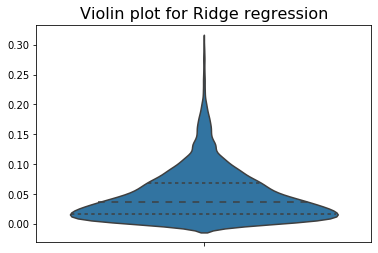

In [29]:
#violin plot for forecasting load
import seaborn as sns

ax = sns.violinplot(y=abs(Y_test-model_predictions["ridge"]), inner='quartile')

ax.set_title('Violin plot for Ridge regression', fontsize=16);

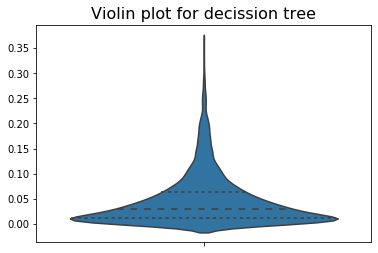

In [30]:
#violin plot for forecasting load
import seaborn as sns

ax = sns.violinplot(y=abs(Y_test-model_predictions["tree"]), inner='quartile')

ax.set_title('Violin plot for decission tree', fontsize=16);

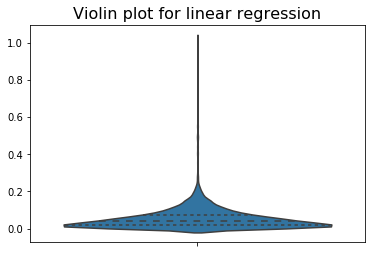

In [31]:
#violin plot for forecasting load
import seaborn as sns

ax = sns.violinplot(y=abs(Y_test-model_predictions["linear_reg"]), inner='quartile')

ax.set_title('Violin plot for linear regression', fontsize=16);

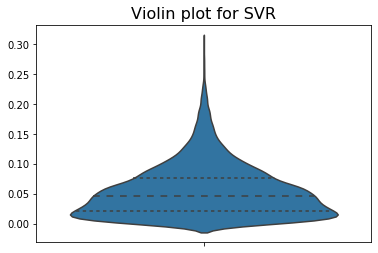

In [32]:
#violin plot for forecasting load
import seaborn as sns

ax = sns.violinplot(y=abs(Y_test-model_predictions["SVR"]), inner='quartile')

ax.set_title('Violin plot for SVR', fontsize=16);

In [33]:
#print median, mean, 25%, 75%, iqr
def details_violin(Y_test, Y_pred):
    y=abs(Y_test-Y_pred)
    median_ae = np.median(y)
    print("median", median_ae)
    mean_ae = np.mean(y)
    print("mean", mean_ae)
    q75, q25 = np.percentile(y, [75 ,25])
    iqr = q75 - q25
    print('q75', q75)
    print('q25', q25)
    print('iqr', iqr)

In [35]:
for prediction in model_predictions:
    print('================='+prediction+'====================')
    details_violin(Y_test, model_predictions[prediction])

=================ridge====================
median 0.03654093247041895
mean 0.04834244587918183
q75 0.0679376587304154
q25 0.017349281913891346
iqr 0.05058837681652406
=================tree====================
median 0.03035474826283069
mean 0.047295369441072065
q75 0.06356211142265025
q25 0.011355601609167404
iqr 0.05220650981348285
=================rf====================
median 0.026131902962330866
mean 0.0398149571010544
q75 0.055636962087041136
q25 0.01080519322199186
iqr 0.044831768865049276
=================SVR====================
median 0.0460652484218253
mean 0.05502870524438996
q75 0.07749194368666029
q25 0.021390565190729627
iqr 0.056101378495930665
=================linear_reg====================
median 0.039372109573774794
mean 0.055355662986197283
q75 0.07442342246961026
q25 0.01729434881275929
iqr 0.057129073656850965


=================ridge====================


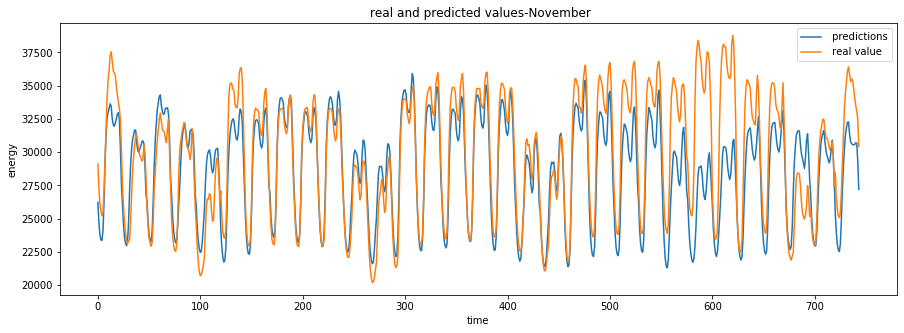

=================tree====================


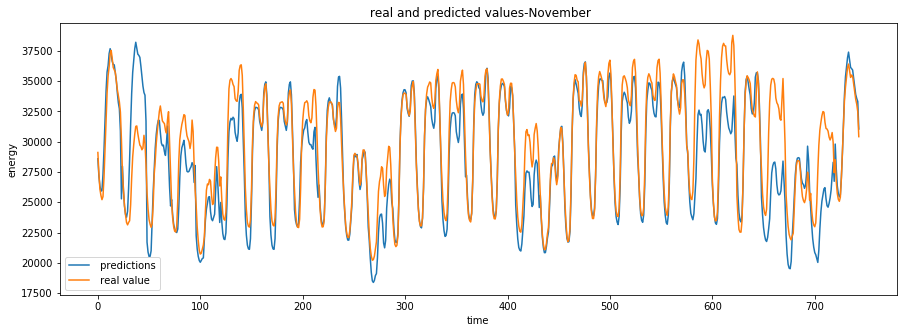

=================rf====================


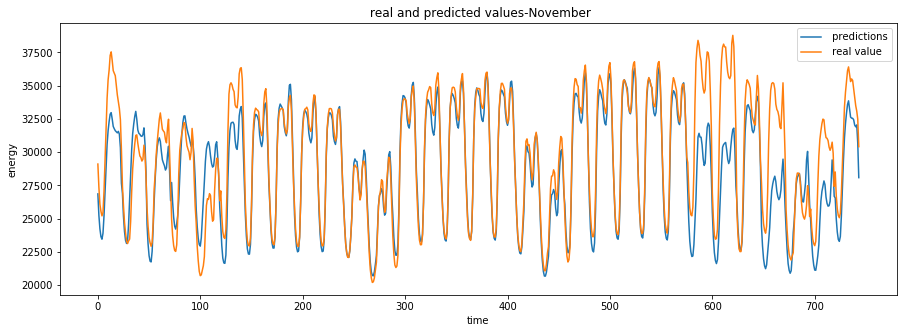

=================SVR====================


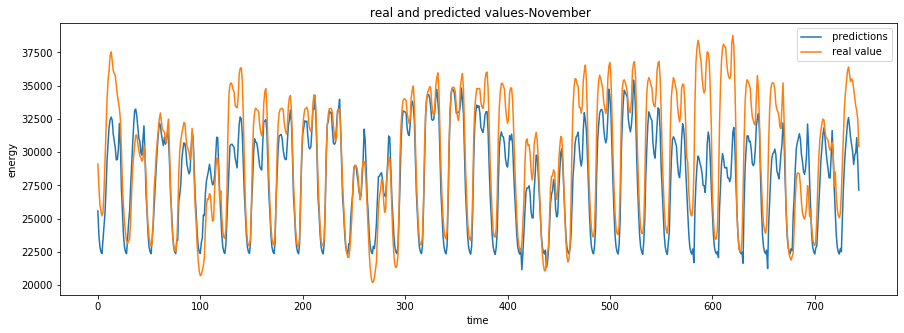

=================linear_reg====================


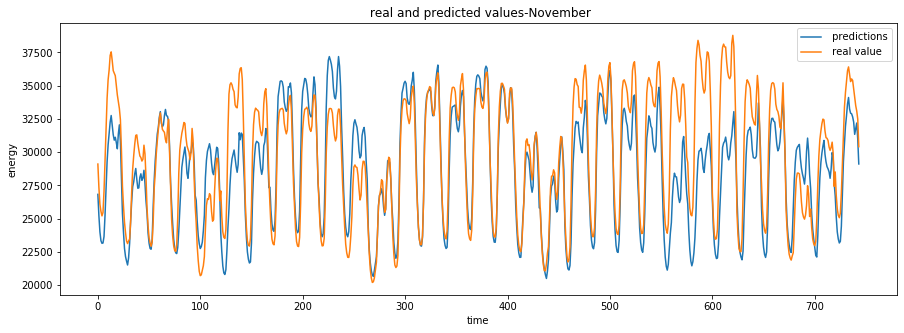

In [36]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
for prediction in model_predictions:
    print('================='+prediction+'====================')
    Month = 11
    Ytest= np.array(Y_test)
    predictions = model_predictions[prediction].flatten()
    actual = Ytest.flatten()
    ac = actual*41015
    pr = predictions*41015
    fig = plt.figure(figsize=(15,5))
    plt.plot(  pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
    plt.plot(  ac[31*24*(Month-1):31*24*Month], label = " real value ")
    plt.xlabel('time')
    plt.ylabel('energy')
    plt.title(' real and predicted values-November')
    plt.legend()
    plt.show()

# three different models

In [85]:
#residual clusters
total_clusters = [[12, 13, 14, 15, 16, 17, 18, 19, 21], [0, 1, 2, 3, 4, 5, 6, 22, 23], [7, 8, 9, 10, 11, 20]]

In [86]:
#create n different dataframes , one of any cluster, to feed n different lstms

def Dataframe_maker(Dataframe, total_clusters):
    import copy
    hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    total_dataframes = []

    for cluster in total_clusters:
        for item in cluster:
            float(item)
        Dataframe['time'] = list(Dataframe.index)
        Dataframe_copy = pd.DataFrame(columns = Dataframe.columns, data = copy.deepcopy(Dataframe.values))
        Dataframe_hour = Dataframe_copy.set_index('hour')
        #find the hours not exist in cluster
        not_in_cluster = list(list(set(cluster)-set(hours)) + list(set(hours)-set(cluster)))
        total_dataframes.append(Dataframe_hour.drop(not_in_cluster))
        
        
    return total_dataframes

In [87]:
total_dataframes = Dataframe_maker(Final_Data, total_clusters)

def prepare_data_for_lstm1(dataframe, first_test_day, days_of_test_set, features, label , window , horizon, black_days, hours):
    X_train = []
    X_test  = []
    Y_train = []
    Y_test  = []
    
    #date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(dataframe.index)]

    date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime 
    id_first_test_day  = days.index(date)  #find the id of first test day in dataframe 
    
    id_first_train_day = window + black_days
    
    id_of_end = id_first_test_day + days_of_test_set * hours
    
 
            
    for i in range( id_first_train_day , id_first_test_day , hours ):
        sample = []
        for j in range( window + black_days, black_days , -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , hours ):
        sample = []
        for j in range( window + black_days, black_days, -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_test, Y_train, Y_test

In [88]:
#prepare training and test data for each cluster
total_X_train = []
total_X_val   = []
total_X_test  = []
total_Y_val   = []
total_Y_train = []

total_Y_test  = []
for i in range(0, len(total_clusters)):
    Dataframe = total_dataframes[i].set_index('time')
    hours              = len(total_clusters[i])     
    label              = 'total load actual'
    window             = hours * 1
    horizon            = hours
    black_days         = hours*1
    start_time1 = datetime.now()
    X_train1, X_val1, X_test1, Y_train1, Y_val1, Y_test1 = prepare_data_for_lstm(dataframe= Dataframe, first_val_day = first_val_day, first_test_day = first_test_day,
                                       days_of_test_set = days_of_test_set, features = features, label = label, 
                                       window = window, horizon = horizon, missing_days = black_days, hours = hours, shape = '2d')
    
    
    start_time2 = datetime.now()
    print(start_time2-start_time1)
    total_X_train.append(X_train1) 
    total_X_val.append(X_val1) 
    total_X_test.append(X_test1) 
    total_Y_train.append(Y_train1) 
    total_Y_val.append(Y_val1)  
    total_Y_test.append(Y_test1) 

0:00:09.081417
0:00:08.867631
0:00:06.139600


In [89]:
for i in range(0,3):
    total_X_train[i] = [flatten_lists(subList) for subList in total_X_train[i]]
    total_X_val[i] = [flatten_lists(subList) for subList in total_X_val[i]]
    total_X_test[i]  = [flatten_lists(subList) for subList in total_X_test[i]]

In [90]:
models = {"ridge":MultiOutputRegressor(Ridge(random_state=0)), "tree":DecisionTreeRegressor(random_state=0),
          "rf":RandomForestRegressor(n_estimators = 2, criterion = 'mse'),
          "SVR":MultiOutputRegressor(SVR(kernel= 'rbf')), "linear_reg":MultiOutputRegressor(LinearRegression())}

models = { name: models[name].fit(total_X_train[0],total_Y_train[0]) for name in models}

model_predictions0 = { name:models[name].predict(total_X_val[0]) for name in models}

#model_MAPE0 = {name: mape(total_Y_test[0],model_predictions0[name]) for name in models}

#model_MSE 

print('Finished base algorithms')

Finished base algorithms


In [91]:
for prediction in model_predictions0:
    print('================='+prediction+'====================')
    evaluation_function(total_Y_val[0], model_predictions0[prediction])
    #yearly_error(Y_test, model_predictions[prediction])

=================ridge====================
MAPE: 8.06783 %
MAE : 0.06023
RMSE: 0.07767
RRMSE: 10.16006 % 
Test R^2 score: 0.22258
=================tree====================
MAPE: 8.18973 %
MAE : 0.06155
RMSE: 0.08696
RRMSE: 11.37604 % 
Test R^2 score: 0.01937
=================rf====================
MAPE: 7.71229 %
MAE : 0.05868
RMSE: 0.08052
RRMSE: 10.53389 % 
Test R^2 score: 0.16290
=================SVR====================
MAPE: 7.95776 %
MAE : 0.06046
RMSE: 0.07627
RRMSE: 9.97668 % 
Test R^2 score: 0.24105
=================linear_reg====================
MAPE: 7.78672 %
MAE : 0.05774
RMSE: 0.07517
RRMSE: 9.83349 % 
Test R^2 score: 0.27259


In [26]:
#model_MAPE0

In [92]:
models = {"ridge":MultiOutputRegressor(Ridge(random_state = 0)), "tree":DecisionTreeRegressor(random_state = 0),
          "rf":RandomForestRegressor(n_estimators = 10, criterion = 'mse'),
          "SVR":MultiOutputRegressor(SVR(kernel= 'rbf')), "linear_reg":MultiOutputRegressor(LinearRegression())}

models = { name: models[name].fit(total_X_train[1],total_Y_train[1]) for name in models}

model_predictions1 = { name:models[name].predict(total_X_val[1]) for name in models}

#model_MAPE1 = {name: mape(total_Y_test[1],model_predictions1[name]) for name in models}

#model_MSE 

print('Finished base algorithms')

Finished base algorithms


In [93]:
for prediction in model_predictions1:
    print('================='+prediction+'====================')
    evaluation_function(total_Y_val[1], model_predictions1[prediction])
    #yearly_error(Y_test, model_predictions[prediction])

=================ridge====================
MAPE: 5.25211 %
MAE : 0.03260
RMSE: 0.04147
RRMSE: 6.71334 % 
Test R^2 score: 0.34285
=================tree====================
MAPE: 5.72201 %
MAE : 0.03510
RMSE: 0.04840
RRMSE: 7.83452 % 
Test R^2 score: 0.09408
=================rf====================
MAPE: 4.46869 %
MAE : 0.02764
RMSE: 0.03606
RRMSE: 5.83641 % 
Test R^2 score: 0.48817
=================SVR====================
MAPE: 6.49466 %
MAE : 0.04051
RMSE: 0.05026
RRMSE: 8.13497 % 
Test R^2 score: 0.02581
=================linear_reg====================
MAPE: 5.23603 %
MAE : 0.03242
RMSE: 0.04171
RRMSE: 6.75098 % 
Test R^2 score: 0.33901


In [28]:
#model_MAPE1

In [94]:
models = {"ridge":MultiOutputRegressor(Ridge(random_state = 0)), "tree":DecisionTreeRegressor(random_state = 0),
          "rf":RandomForestRegressor(n_estimators = 10, criterion = 'mse'),
          "SVR":MultiOutputRegressor(SVR(kernel= 'rbf')), "linear_reg":MultiOutputRegressor(LinearRegression())}

models = { name: models[name].fit(total_X_train[2],total_Y_train[2]) for name in models}

model_predictions2 = { name:models[name].predict(total_X_val[2]) for name in models}

#model_MAPE2 = {name: mape(total_Y_val[2],model_predictions2[name]) for name in models}

#model_MSE 

print('Finished base algorithms')

Finished base algorithms


In [95]:
for prediction in model_predictions2:
    print('================='+prediction+'====================')
    evaluation_function(total_Y_val[2], model_predictions2[prediction])

=================ridge====================
MAPE: 8.73323 %
MAE : 0.06256
RMSE: 0.08029
RRMSE: 10.83374 % 
Test R^2 score: 0.25827
=================tree====================
MAPE: 8.47272 %
MAE : 0.05974
RMSE: 0.09034
RRMSE: 12.19006 % 
Test R^2 score: 0.06565
=================rf====================
MAPE: 6.87574 %
MAE : 0.04920
RMSE: 0.06921
RRMSE: 9.33890 % 
Test R^2 score: 0.45079
=================SVR====================
MAPE: 8.89679 %
MAE : 0.06480
RMSE: 0.07921
RRMSE: 10.68758 % 
Test R^2 score: 0.27472
=================linear_reg====================
MAPE: 8.76272 %
MAE : 0.06248
RMSE: 0.08065
RRMSE: 10.88179 % 
Test R^2 score: 0.25178


In [96]:
for prediction in model_predictions2:
    print('================='+prediction+'====================')
    new_Y_pred_1 = [  list(item)  for item in model_predictions0[prediction]]
    new_Y_pred_2 = [  list(item)  for item in model_predictions1[prediction]]
    new_Y_pred_3 = [  list(item)  for item in model_predictions2[prediction]]
    
    total_Y_pred = [item1 + item2 + item3 for item1,item2,item3 in zip(new_Y_pred_1,new_Y_pred_2,new_Y_pred_3)]
    total_Y_true = [item1 + item2 + item3 for item1,item2,item3 in zip(total_Y_val[0],total_Y_val[1],total_Y_val[2])]
    evaluation_function(np.array(total_Y_true),np.array(total_Y_pred))
    #yearly_error(np.array(total_Y_true),np.array(total_Y_pred))

=================ridge====================
MAPE: 7.17828 %
MAE : 0.05045
RMSE: 0.06722
RRMSE: 9.55382 % 
Test R^2 score: 0.27660
=================tree====================
MAPE: 7.33508 %
MAE : 0.05118
RMSE: 0.07586
RRMSE: 10.78164 % 
Test R^2 score: 0.05896
=================rf====================
MAPE: 6.28680 %
MAE : 0.04467
RMSE: 0.06416
RRMSE: 9.11889 % 
Test R^2 score: 0.35685
=================SVR====================
MAPE: 7.64385 %
MAE : 0.05406
RMSE: 0.06853
RRMSE: 9.74016 % 
Test R^2 score: 0.16875
=================linear_reg====================
MAPE: 7.07421 %
MAE : 0.04943
RMSE: 0.06631
RRMSE: 9.42450 % 
Test R^2 score: 0.29230
